In [7]:
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('C:\\Users\\dell\\Desktop\\phasemapy')
import os
from copy import deepcopy
from scipy.constants import h, c, e
from pymatgen.core import Element
from monty.json import MontyDecoder, MontyEncoder
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
from phasemapy.dataio import InstanceData
from phasemapy.parser import ICDDEntry,ICDDEntriesBiCuV
from phasemapy.solver import Phase, Sample
import matplotlib.pyplot as plt
chemsys = ['Bi', 'Cu', 'V']
oxide_system = True
photon_e = 13e3
max_q_shift = 0.05
resample_density = 1000
initial_alphagamma = 0.1
SUM_NORM = 6000

In [2]:
loss_weight = {'xrd_loss': 6.0, 'comp_loss': 2.0, 'entropy_loss': 0.2}

In [3]:
#load entry pool: 100 ICDD entries
with open('ICDD_entries_Bi_Cu_V.json') as f:
    entries_Bi_Cu_V = json.load(f, cls=MontyDecoder)

In [4]:
entries = [ICDDEntriesBiCuV.from_ICDD_Bi_Cu_V(en) for en in entries_Bi_Cu_V]

In [5]:
instance_data = InstanceData.from_file_BiCuV('Instance_data_Bi_Cu_V', chemsys, photon_e)

In [8]:
#解析未知相
k=10
solution = []
for ent in entries:
    phase = Phase.from_entry_and_instance_data(ent, 1/len(entries), instance_data)
    solution.append(phase)

sample = Sample(k, instance_data.log_q, instance_data.sample_xrd[k], instance_data.chemsys,
                        instance_data.sample_comp[k], oxide_system, instance_data.wavelength, max_q_shift, solution)


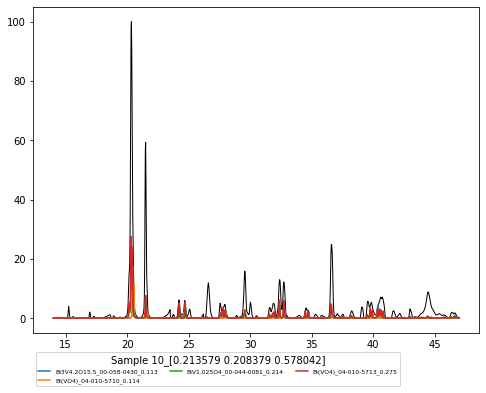

In [10]:
sample.prune_candidates_based_on_composition(cutoff=0.4)
sample.prune_candidate_based_on_xrd(plot=True, cutoff=0.05)

In [11]:
sample.print_solution()

Sample: # 10
           Name     Entry_id  fraction     shift  width
0       Bi(VO4)  04-010-5713  0.289306  0.001969   0.03
1    BiV1.025O4  00-044-0081  0.222541  0.003937   0.03
2       Bi(VO4)  04-010-5710  0.245730  0.015748   0.03
3  Bi3V4.2O15.5  00-058-0430  0.242422  0.007874   0.03
Current R^2 = 58394.42347284433


<module 'matplotlib.pyplot' from 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\matplotlib\\pyplot.py'>

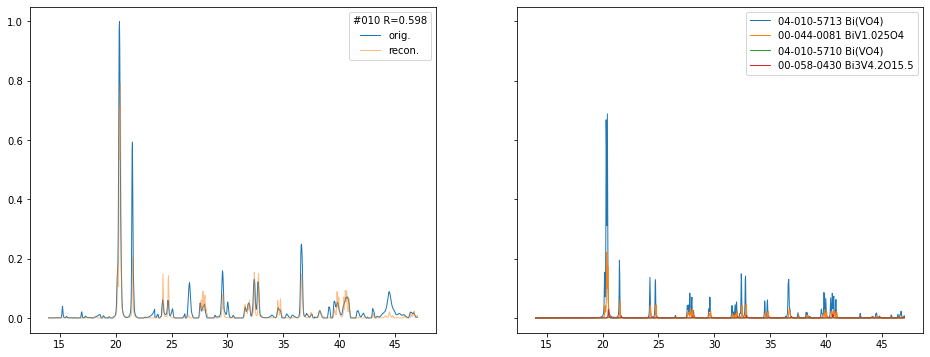

In [12]:
sample.refine_all_fractions()
# sample.refine_one_by_one()
sample.plot(perphase=True)